# Preprocesamiento

In [2]:
from datasets import load_dataset

dataset = load_dataset("go_emotions")

C:\Users\mccaj\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Exploracion

In [3]:
print(dataset['train'][0]) #Muestra filas del dataset de entrenamiento

emotion_labels = dataset['train'].features["labels"].feature.names
emotion_labels[27]

{'text': "My favourite food is anything I didn't have to cook myself.", 'labels': [27], 'id': 'eebbqej'}


'neutral'

In [4]:
#Filtro de una sola emoción
import pandas as pd

#Monstrar emociones unicas
print("Emociones únicas:", emotion_labels)
print("Número de emociones únicas:", len(emotion_labels))

df = pd.DataFrame(dataset["train"])
#Filtro de las filas con una sola emoción
df = df[df['labels'].map(len) == 1]

df['emotion'] = df['labels'].apply(lambda x: emotion_labels[x[0]])
#Texto y emoción 
df = df[['text', 'emotion']]

df.head()




Emociones únicas: ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']
Número de emociones únicas: 28


,text,emotion
0,My favourite food is anything I didn't have to...,neutral
1,"Now if he does off himself, everyone will thin...",neutral
2,WHY THE FUCK IS BAYLESS ISOING,anger
3,To make her feel threatened,fear
4,Dirty Southern Wankers,annoyance


### Limpieza de texto

In [5]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text) #Elimina puntuacion
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['clean_text'] = df['text'].apply(clean_text)

df[['text', 'clean_text', 'emotion']].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mccaj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,text,clean_text,emotion
0,My favourite food is anything I didn't have to...,favourite food anything didnt cook,neutral
1,"Now if he does off himself, everyone will thin...",everyone think hes laugh screwing people inste...,neutral
2,WHY THE FUCK IS BAYLESS ISOING,fuck bayless isoing,anger
3,To make her feel threatened,make feel threatened,fear
4,Dirty Southern Wankers,dirty southern wankers,annoyance


### Anlasis exploratorio

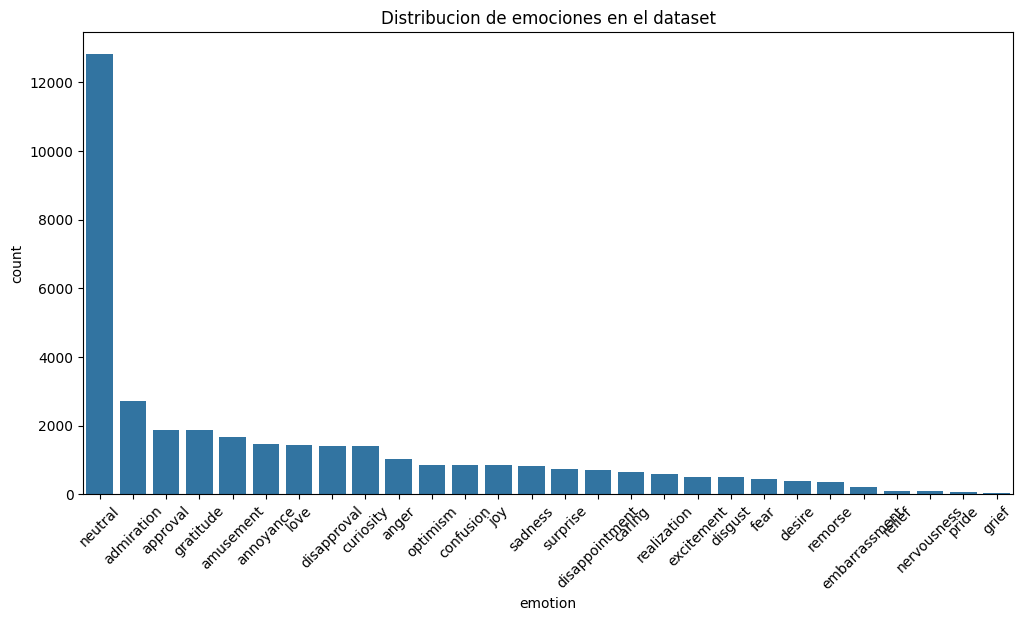

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='emotion', order=df['emotion'].value_counts().index)
plt.title("Distribucion de emociones en el dataset")
plt.xticks(rotation=45)
plt.show()

### Vectorizacion de texto 

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

X_texts = df['clean_text']
y = df['emotion']

vectorizer = TfidfVectorizer(max_features=5000)
X_vec = vectorizer.fit_transform(X_texts)

print("Shape del vector TF-IDF: ", X_vec.shape)

Shape del vector TF-IDF:  (36308, 5000)


### Aplicar sobremuestreo

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_vec, y)


pd.Series(y_resampled).value_counts()


emotion
neutral           12823
anger             12823
desire            12823
grief             12823
pride             12823
relief            12823
disgust           12823
realization       12823
curiosity         12823
love              12823
remorse           12823
disappointment    12823
amusement         12823
excitement        12823
approval          12823
optimism          12823
disapproval       12823
sadness           12823
joy               12823
embarrassment     12823
caring            12823
confusion         12823
admiration        12823
gratitude         12823
surprise          12823
annoyance         12823
fear              12823
nervousness       12823
Name: count, dtype: int64

### Entrenamiento del modelo

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train,  y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

### Evaluacion del modelo

                precision    recall  f1-score   support

    admiration      0.778     0.739     0.758      2564
     amusement      0.872     0.903     0.887      2565
         anger      0.819     0.852     0.835      2565
     annoyance      0.753     0.655     0.700      2565
      approval      0.701     0.611     0.652      2565
        caring      0.836     0.912     0.872      2565
     confusion      0.788     0.822     0.805      2565
     curiosity      0.752     0.628     0.685      2565
        desire      0.918     0.986     0.951      2564
disappointment      0.809     0.878     0.842      2564
   disapproval      0.741     0.714     0.727      2565
       disgust      0.879     0.933     0.905      2564
 embarrassment      0.962     0.982     0.972      2564
    excitement      0.839     0.908     0.872      2564
          fear      0.936     0.974     0.954      2565
     gratitude      0.971     0.932     0.951      2564
         grief      0.991     1.000     0.996  

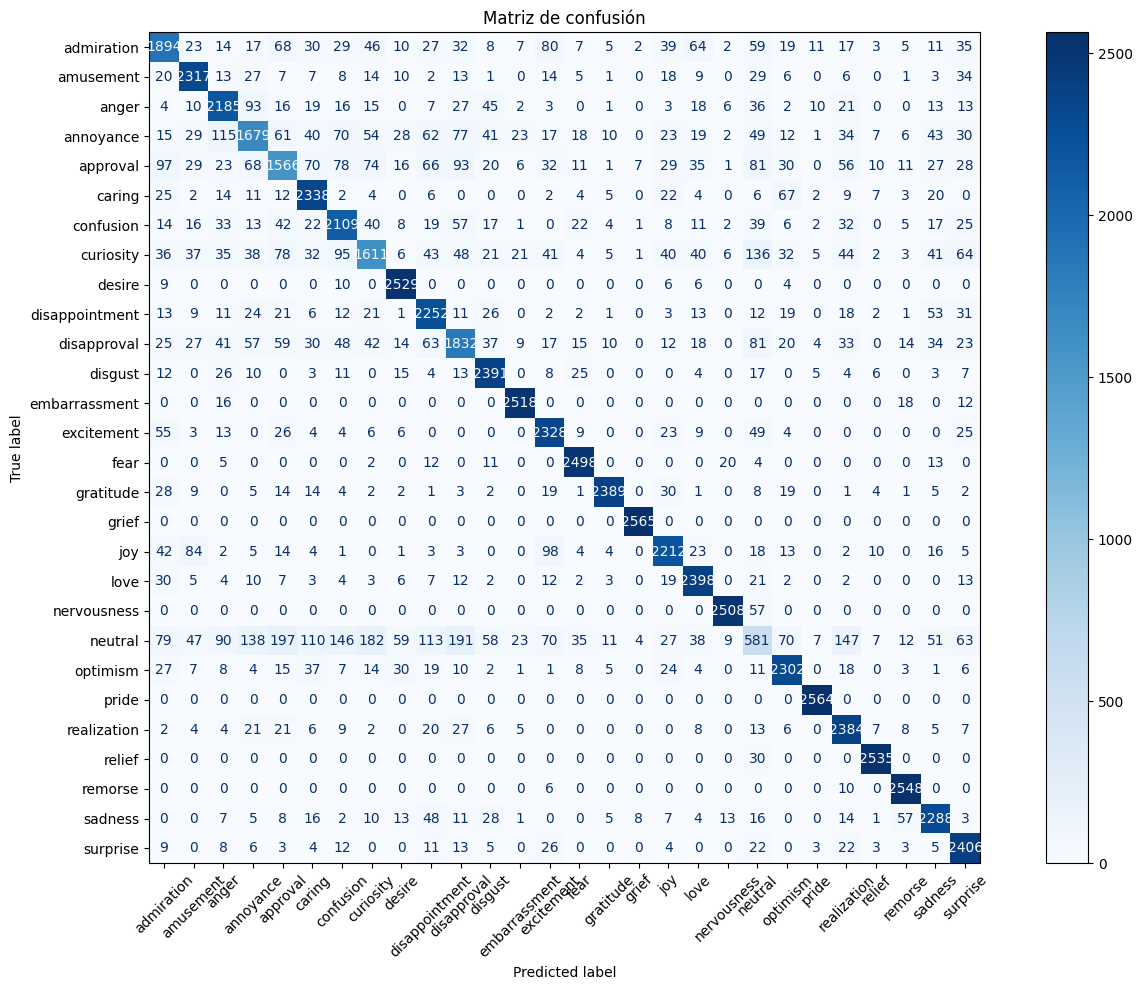

In [10]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

#Predicciones
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, digits=3))

#Matriz de confusion
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
fig, ax = plt.subplots(figsize=(14, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(ax=ax, xticks_rotation=45, cmap='Blues')


plt.title("Matriz de confusión")
plt.tight_layout()
plt.show()


### Guardar modelo y vectorizador

In [11]:
import joblib

joblib.dump(model, "modelo_emociones.pkl")
joblib.dump(vectorizer, "vectorizador_tfidf.pkl")

['vectorizador_tfidf.pkl']